Epoch 1/20
Train Loss: 2.2988, Train Acc: 0.2670, Test Acc: 0.2590
Epoch 2/20
Train Loss: 1.2590, Train Acc: 0.5760, Test Acc: 0.5110
Epoch 3/20
Train Loss: 0.7266, Train Acc: 0.7340, Test Acc: 0.7030
Epoch 4/20
Train Loss: 0.6351, Train Acc: 0.7720, Test Acc: 0.7560
Epoch 5/20
Train Loss: 0.5787, Train Acc: 0.7850, Test Acc: 0.7620
Epoch 6/20
Train Loss: 0.5294, Train Acc: 0.8090, Test Acc: 0.8000
Epoch 7/20
Train Loss: 0.5176, Train Acc: 0.8160, Test Acc: 0.8160
Epoch 8/20
Train Loss: 0.4916, Train Acc: 0.8160, Test Acc: 0.7970
Epoch 9/20
Train Loss: 0.4644, Train Acc: 0.8430, Test Acc: 0.8160
Epoch 10/20
Train Loss: 0.4242, Train Acc: 0.8510, Test Acc: 0.8230
Epoch 11/20
Train Loss: 0.4651, Train Acc: 0.8390, Test Acc: 0.8150
Epoch 12/20
Train Loss: 0.4113, Train Acc: 0.8540, Test Acc: 0.8340
Epoch 13/20
Train Loss: 0.4173, Train Acc: 0.8610, Test Acc: 0.8240
Epoch 14/20
Train Loss: 0.3884, Train Acc: 0.8470, Test Acc: 0.8370
Epoch 15/20
Train Loss: 0.3887, Train Acc: 0.8660, Test A

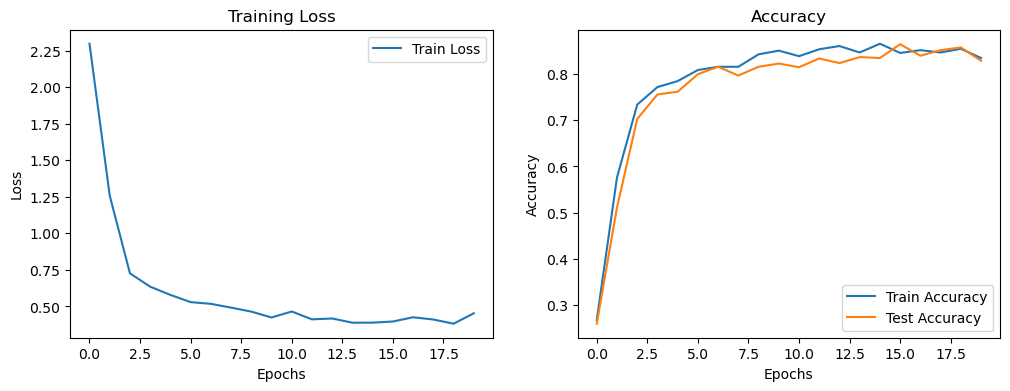

In [6]:
import os
import numpy as np
import gzip
import matplotlib.pyplot as plt
from collections import OrderedDict


base_path = r'C:\Users\pc\deeprunning\fashion-mnist-master\data\fashion'
train_images_path = os.path.join(base_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(base_path, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(base_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(base_path, 't10k-labels-idx1-ubyte.gz')


def load_images(file_path):
    with gzip.open(file_path, 'r') as f:
        f.read(16)  
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        data = data.reshape(-1, 1, 28, 28)
    return data

def load_labels(file_path):
    with gzip.open(file_path, 'r') as f:
        f.read(8)  
        buffer = f.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)
    return labels

def to_categorical(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    for idx, val in enumerate(labels):
        one_hot[idx, val] = 1
    return one_hot


train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)


train_images /= 255.0
test_images /= 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

class Relu:
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = np.argmax(col, axis=1)
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.orig_shape)

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

class SoftmaxWithLoss:
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

def softmax(x):
    if x.ndim == 2:
        x = x - np.max(x, axis=1, keepdims=True)
        x = np.exp(x)
        x = x / np.sum(x, axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = int((input_size - filter_size + 2*filter_pad) / filter_stride + 1)
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Flatten'] = Flatten()
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


input_dim = (1, 28, 28)
conv_param = {'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1}
hidden_size = 100
output_size = 10
weight_init_std = 0.01

model = SimpleConvNet(input_dim=input_dim, 
                      conv_param=conv_param, 
                      hidden_size=hidden_size, 
                      output_size=output_size, 
                      weight_init_std=weight_init_std)


learning_rate = 0.01
batch_size = 100
epochs = 20


train_loss_list = []
train_acc_list = []
test_acc_list = []


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    idx = np.random.permutation(len(train_images))
    train_images = train_images[idx]
    train_labels = train_labels[idx]

    for i in range(0, len(train_images), batch_size):
        x_batch = train_images[i:i+batch_size]
        t_batch = train_labels[i:i+batch_size]
        
       
        grad = model.gradient(x_batch, t_batch)
        
        
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            model.params[key] -= learning_rate * grad[key]
    
    
    idx = np.random.permutation(len(train_images))[:1000]
    train_loss = model.loss(train_images[idx], train_labels[idx])
    train_loss_list.append(train_loss)
    
    
    train_acc = model.accuracy(train_images[idx], train_labels[idx])
    train_acc_list.append(train_acc)
    
    
    idx = np.random.permutation(len(test_images))[:1000]
    test_acc = model.accuracy(test_images[idx], test_labels[idx])
    test_acc_list.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()
